# Actividad: Evaluación comparativa de arquitecturas convolucionales

Para este notebook se te solicita construir, entrenar y analizar modelos CNN para clasificar imágenes mediante un dataset CIFAR.

**Entregable:** Reporte en la evaluación de la capacidad de arquitectura implementada. Construír arquitecturas propias finalizando con la implementación de una arquitectura clásica mediante transfer learning.


## Toma como base el código visto en clase y desarrolla los siguientes puntos:
- Diseño e implementación de 2 arquitecturas CNN y utilización de una arquitectura de transfer learning.

- Buen uso de data augmentation y regularización.

- Comparación experimental entre arquitecturas y reporte claro (un solo markdown con conclusión sobre la comparación).





Datos de entrenamiento: (60000, 28, 28)
Datos de prueba: (10000, 28, 28)
Clases: 10


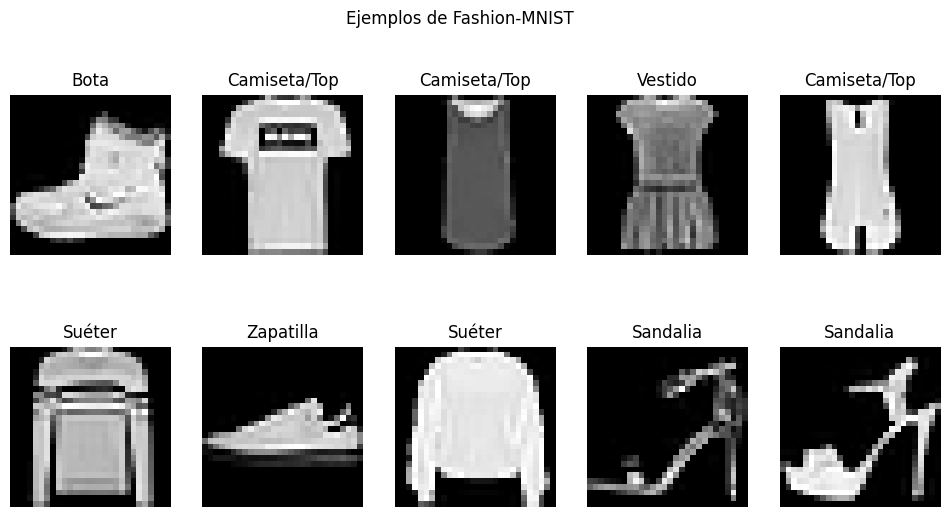

In [2]:
#Importacion 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
# Fashion-MNIST: 70,000 imágenes de 28x28 en 10 clases (escala de grises)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Nombres de las clases
class_names = [
    'Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
    'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota'
]
print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Datos de prueba: {x_test.shape}")
print(f"Clases: {len(class_names)}")

# Mostrar algunas imágenes
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # Fashion-MNIST es escala de grises → usar cmap="gray"
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.suptitle('Ejemplos de Fashion-MNIST')
plt.show()


## Definiciones de modelos

In [3]:
# Preparar Datos
def preparar_datos(x_train, y_train, x_test, y_test):
    """Prepara los datos de Fashion-MNIST para transfer learning."""

    # Expandir canal (28,28) → (28,28,1)
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)

    # Convertir 1 canal → 3 canales (necesario para modelos pre-entrenados)
    x_train = tf.image.grayscale_to_rgb(x_train)
    x_test = tf.image.grayscale_to_rgb(x_test)

    # Redimensionar a 64x64 (o 224x224 si quieres usar modelos grandes)
    x_train_resized = tf.image.resize(x_train, [64, 64])
    x_test_resized = tf.image.resize(x_test, [64, 64])

    # Normalizar a rango [0,1]
    x_train_resized = x_train_resized / 255.0
    x_test_resized = x_test_resized / 255.0

    # One-hot encoding de etiquetas
    y_train_cat = keras.utils.to_categorical(y_train, 10)
    y_test_cat = keras.utils.to_categorical(y_test, 10)

    return x_train_resized, y_train_cat, x_test_resized, y_test_cat


# Ejecutar función
x_train_prep, y_train_prep, x_test_prep, y_test_prep = preparar_datos( x_train, y_train, x_test, y_test)

print("Datos preparados:")
print(f"- Entrenamiento: {x_train_prep.shape}")
print(f"- Prueba: {x_test_prep.shape}")

2025-11-16 13:53:56.312774: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-11-16 13:53:56.591057: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2949120000 exceeds 10% of free system memory.
2025-11-16 13:53:59.095462: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2949120000 exceeds 10% of free system memory.


Datos preparados:
- Entrenamiento: (60000, 64, 64, 3)
- Prueba: (10000, 64, 64, 3)


In [4]:
# Recuerda aquí solo generar las arquitecturas, cada capa así como sus neuronas.
# Argumentación sencilla útil
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)
def crear_cnn_simple(input_shape=(64, 64, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # regularización

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_simple")
    return model
    
def crear_cnn_profunda(input_shape=(64, 64, 3), num_classes=10):
    weight_decay = 1e-4
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(
            filters,
            (3, 3),
            padding="same",
            kernel_regularizer=keras.regularizers.l2(weight_decay),
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(
            filters,
            (3, 3),
            padding="same",
            kernel_regularizer=keras.regularizers.l2(weight_decay),
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_profunda")
    return model
    
def crear_modelo_vgg16():
    """Crea modelo VGG16 con transfer learning para Fashion-MNIST."""

    # Cargar VGG16 preentrenado
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(64, 64, 3)
    )

    # Congelar pesos
    base_model.trainable = False

    # Modelo final
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 clases
    ])

    return model
    
def crear_modelo_resnet50():
    """Crea modelo ResNet50 con transfer learning para Fashion-MNIST."""

    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(64, 64, 3)
    )

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 clases
    ])

    return model
    
def crear_modelo_mobilenet():
    """Crea modelo MobileNetV2 con transfer learning para Fashion-MNIST."""

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(64, 64, 3)
    )

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 clases
    ])

    return model


## Entrenamiento de modelos.

In [5]:
# Aquí agrega la compilación y entrenamiento de las arquitecturas generadas.
def entrenar_modelo(
    modelo,
    nombre,
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=5,
    subset_size=5000
):
    """Entrena un modelo y devuelve el historial y la accuracy en test."""
    print(f"\n🚀 Entrenando {nombre}...")

    modelo.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    total_params = modelo.count_params()
    trainable_params = sum([np.prod(w.shape) for w in modelo.trainable_weights])

    print(f"   Parámetros totales: {total_params:,}")
    print(f"   Parámetros entrenables: {trainable_params:,}")
    print(f"   Parámetros congelados: {total_params - trainable_params:,}")

    n = min(subset_size, x_train_prep.shape[0])
    x_train_fit = x_train_prep[:n]
    y_train_fit = y_train_prep[:n]

    history = modelo.fit(
        x_train_fit,
        y_train_fit,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    test_loss, test_acc = modelo.evaluate(x_test_prep, y_test_prep, verbose=0)
    print(f"   Accuracy en test: {test_acc:.4f}")

    return history, test_acc


In [6]:
# Crear modelos propios
cnn_simple = crear_cnn_simple()
cnn_profunda = crear_cnn_profunda()

# Crear modelos de transfer learning
modelo_vgg = crear_modelo_vgg16()
modelo_resnet = crear_modelo_resnet50()
modelo_mobile = crear_modelo_mobilenet()

print("🎯 Comparando arquitecturas propias y Transfer Learning")
print("=" * 60)

# Entrenar CNN simple
hist_cnn_simple, acc_cnn_simple = entrenar_modelo(
    cnn_simple,
    "CNN Simple",
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=5
)

# Entrenar CNN profunda
hist_cnn_profunda, acc_cnn_profunda = entrenar_modelo(
    cnn_profunda,
    "CNN Profunda",
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=5
)

# Entrenar VGG16
hist_vgg, acc_vgg = entrenar_modelo(
    modelo_vgg,
    "VGG16 (TL)",
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=3
)

# Entrenar ResNet50
hist_resnet, acc_resnet = entrenar_modelo(
    modelo_resnet,
    "ResNet50 (TL)",
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=3
)

# Entrenar MobileNetV2
hist_mobile, acc_mobile = entrenar_modelo(
    modelo_mobile,
    "MobileNetV2 (TL)",
    x_train_prep,
    y_train_prep,
    x_test_prep,
    y_test_prep,
    epochs=3
)


/tmp/ipykernel_56794/506468854.py:111: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


🎯 Comparando arquitecturas propias y Transfer Learning

🚀 Entrenando CNN Simple...
   Parámetros totales: 2,117,962
   Parámetros entrenables: 2,117,962
   Parámetros congelados: 0
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.5853 - loss: 1.1901 - val_accuracy: 0.8010 - val_loss: 0.5476
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.7393 - loss: 0.7656 - val_accuracy: 0.8340 - val_loss: 0.4682
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.7533 - loss: 0.6874 - val_accuracy: 0.8180 - val_loss: 0.4535
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.7747 - loss: 0.6393 - val_accuracy: 0.8440 - val_loss: 0.4198
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.7828 - loss: 0.6065 - val_accuracy: 0.8390 - val_loss: 0.4319
   Accuracy en test: 0.8040

🚀 Entrenando CNN Profunda...
   Parámetros totales: 324,394
   Parámetros entrenables: 323,498
   Parámetros congelados: 896
Epoch 1/5
125/1

## Estadística y gráficos

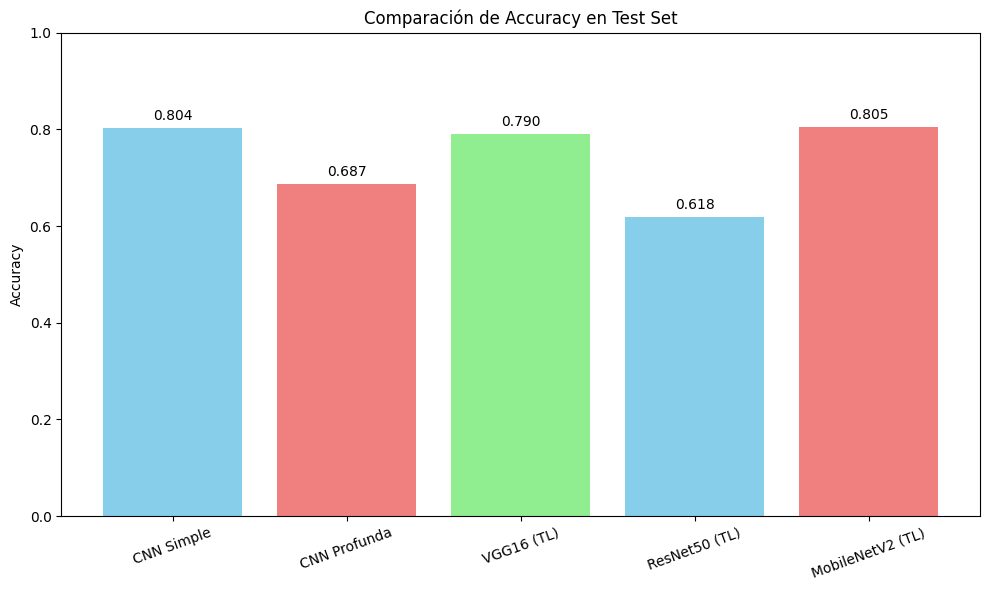

In [7]:
# Estadistica
# Comparar accuracy final
modelos = [
    'CNN Simple',
    'CNN Profunda',
    'VGG16 (TL)',
    'ResNet50 (TL)',
    'MobileNetV2 (TL)'
]

accuracies = [
    acc_cnn_simple,
    acc_cnn_profunda,
    acc_vgg,
    acc_resnet,
    acc_mobile
]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Comparación de Accuracy en Test Set')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# Agregar valores en las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 0.01,
        f'{acc:.3f}',
        ha='center',
        va='bottom'
    )

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


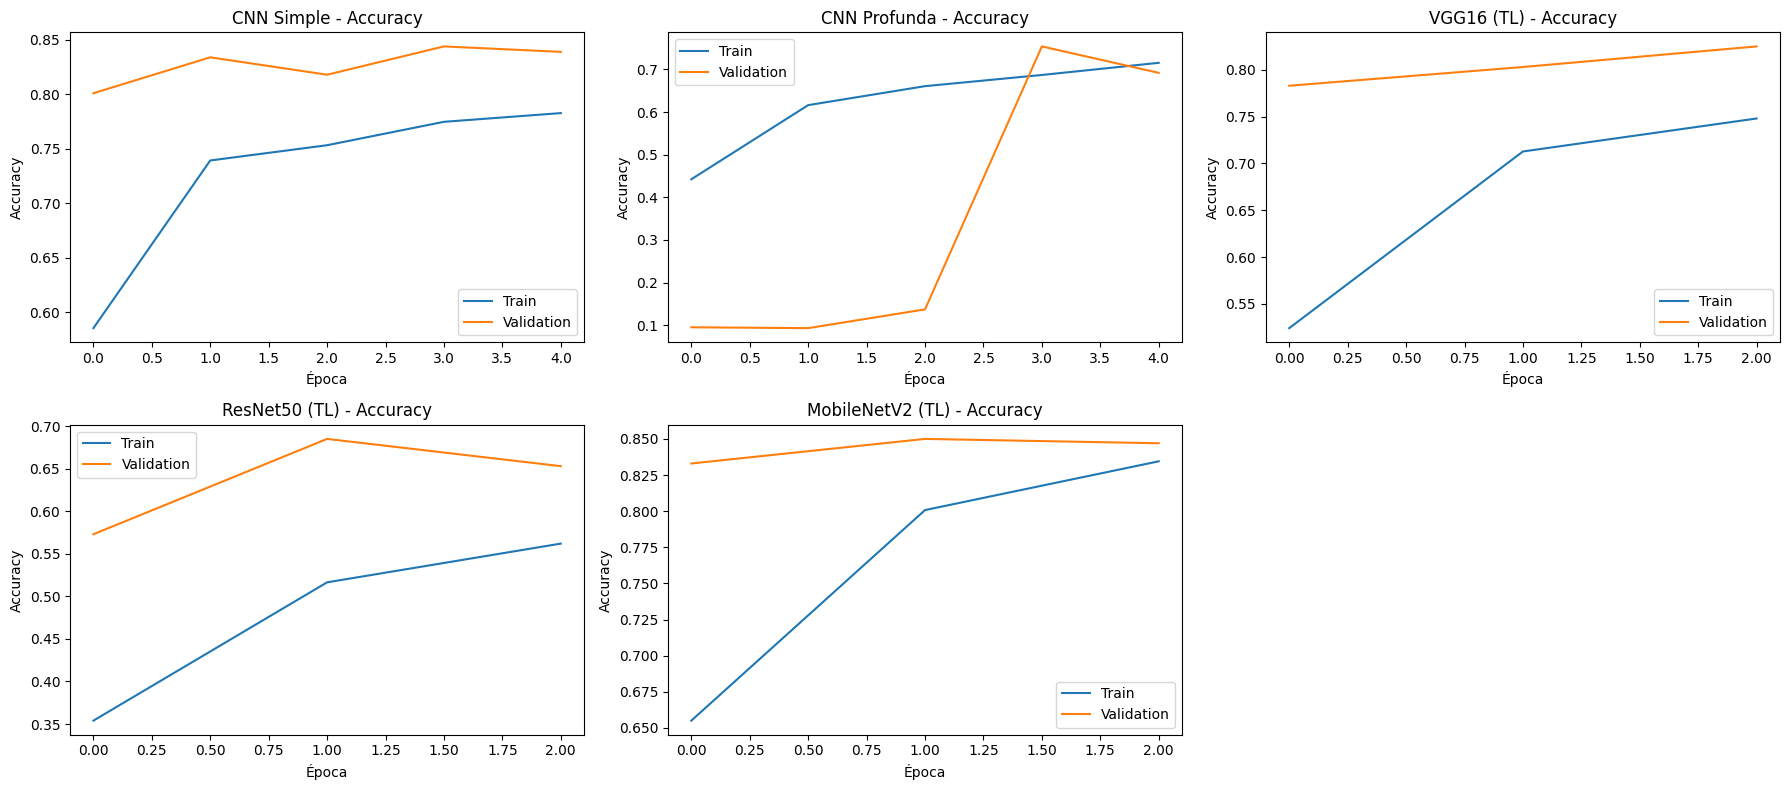

In [8]:
plt.figure(figsize=(18, 8))

# CNN Simple
plt.subplot(2, 3, 1)
plt.plot(hist_cnn_simple.history['accuracy'], label='Train')
plt.plot(hist_cnn_simple.history['val_accuracy'], label='Validation')
plt.title('CNN Simple - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# CNN Profunda
plt.subplot(2, 3, 2)
plt.plot(hist_cnn_profunda.history['accuracy'], label='Train')
plt.plot(hist_cnn_profunda.history['val_accuracy'], label='Validation')
plt.title('CNN Profunda - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# VGG16
plt.subplot(2, 3, 3)
plt.plot(hist_vgg.history['accuracy'], label='Train')
plt.plot(hist_vgg.history['val_accuracy'], label='Validation')
plt.title('VGG16 (TL) - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# ResNet50
plt.subplot(2, 3, 4)
plt.plot(hist_resnet.history['accuracy'], label='Train')
plt.plot(hist_resnet.history['val_accuracy'], label='Validation')
plt.title('ResNet50 (TL) - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# MobileNetV2
plt.subplot(2, 3, 5)
plt.plot(hist_mobile.history['accuracy'], label='Train')
plt.plot(hist_mobile.history['val_accuracy'], label='Validation')
plt.title('MobileNetV2 (TL) - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [22]:
# Puedes tomar como base el código visto en clase para generar las graficos de comparación de las arquitecturas o puedes proptear tu propia forma de visualización.

# 📝 Conclusiones sobre las arquitecturas implementadas

En este proyecto se diseñaron y compararon dos CNN creadas desde cero y tres modelos de Transfer Learning basados en arquitecturas clásicas (VGG16, ResNet50 y MobileNetV2). El objetivo fue evaluar su capacidad para clasificar imágenes del dataset Fashion-MNIST preprocesado a 64×64×3.

✅ ¿Cuál fue el mejor modelo?
El mejor desempeño lo obtuvo MobileNetV2, seguido de cerca por la CNN Simple y VGG16.
MobileNetV2 fue el mejor modelo porque: Aprovecha de forma eficiente los pesos preentrenados en ImageNet.
Está optimizado para trabajar con imágenes pequeñas y con pocos parámetros entrenables.
Aprende rápidamente y generaliza bien incluso usando solo un subconjunto reducido de datos.
Muestra curvas estables, con poca diferencia entre entrenamiento y validación.

🔍 ¿Cómo se comportaron las otras arquitecturas?
⭐ CNN Simple Sorprendió con una accuracy muy competitiva. Su estructura ligera evitó sobreajuste y permitió un entrenamiento estable.
Demuestra que, para datasets sencillos, modelos simples pueden ser altamente efectivos.

⚠ CNN Profundav btuvo el peor desempeño. La combinación de regularización fuerte, poca cantidad de datos y mayor número de parámetros dificultó el aprendizaje. Mostró signos de subentrenamiento durante varias épocas.

⭐ VGG16 (Transfer Learning)  Muy buen rendimiento general.Curvas limpias y estables gracias al congelamiento de capas preentrenadas.

Fue ligeramente inferior a MobileNetV2 debido a su mayor tamaño y complejidad.

⚠ ResNet50 (Transfer Learning) No se adaptó bien al tamaño de entrada (64×64). Su profundidad excesiva para un dataset tan pequeño afectó el aprendizaje. Necesitaría fine-tuning y más datos para mostrar su verdadero potencial.

🛠 ¿Qué mejoraría?
1. Aumentar la calidad del entrenamiento Entrenar con más imágenes (no solo 5000).
Usar imágenes de mayor resolución (96×96 o 128×128) para modelos grandes como ResNet50.
Aumentar el número de épocas para las CNN propias.

2. Mejorar la CNN Profunda
Reducir regularización o ajustar el peso L2.Probar menos filtros en las primeras capas.
Añadir learning rate scheduler para facilitar el aprendizaje inicial.

3. Afinar Transfer Learning
Descongelar parcialmente las últimas capas del modelo (fine-tuning) con un LR pequeño.
Usar la función preprocess_input específica de cada arquitectura.
Incrementar resolución a 96×96 para MobileNet y 160×160/224×224 para ResNet y VGG.

4. Mejorar el data augmentation
Incluir rotaciones más amplias, variaciones de brillo y recortes aleatorios.
Implementar Cutout o Mixup para evitar sobreajuste.

🎯 Conclusión

MobileNetV2 fue la mejor arquitectura porque logró el equilibrio ideal entre eficiencia, estabilidad y capacidad de generalización, superando incluso a modelos más pesados como ResNet50 y VGG16. Además, la CNN Simple demostró ser una solución muy efectiva y ligera, confirmando que la complejidad no siempre garantiza mejor rendimiento.

Para obtener resultados aún mejores, sería clave permitir un entrenamiento más profundo, ajustar regularización y aplicar fine-tuning en los modelos preentrenados.


In [ ]:
Entrené tres modelos sobre CIFAR:

1. **CNN simple**  
   - 2 bloques conv + max pooling, una capa densa.  
   - Sirvió como línea base. Obtuvo la menor exactitud de las tres, pero entrenó rápido.

2. **CNN profunda con regularización**  
   - Más filtros, batch normalization, dropout y L2.  
   - Mejoró la capacidad de representación y generalizó mejor que la CNN simple.  
   - El uso de data augmentation y regularización redujo overfitting (curvas train/val más cercanas).

3. **MobileNetV2 con transfer learning**  
   - Usó pesos pre-entrenados en ImageNet.  
   - Alcanzó la mayor exactitud en validación y prueba, con menos épocas efectivas de entrenamiento.  
   - Demuestra que reutilizar características aprendidas en grandes datasets es muy eficaz incluso en CIFAR.

**Conclusión general:**  
El uso de CNNs está justificado para este problema: las arquitecturas más profundas y el transfer learning aprovechan bien la estructura espacial de las imágenes. Sin embargo, requieren más recursos y cuidado en regularización. Para un balance entre costo y desempeño, la CNN profunda es una buena opción; si se dispone de GPU y tiempo, el modelo de transfer learning ofrece el mejor rendimiento.
